In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import altair as alt
import shap

from interaction_effects.marginal import MarginalExplainer
from interaction_effects import utils

In [3]:
n = 1000
d = 3
batch_size = 50
learning_rate = 0.1

In [4]:
W = np.array([-2.0, -3.0, 1.0])
b = 0.0
X = np.random.randn(n, d)
y = np.dot(X, W) + b

In [5]:
model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(3,), batch_size=batch_size))
model.add(tf.keras.layers.Dense(1, activation=None, use_bias=True))

In [6]:
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.MSE,
              metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.MeanSquaredError()])

In [7]:
model.fit(X, y, epochs=10, verbose=2)

Train on 1000 samples
Epoch 1/10
1000/1000 - 0s - loss: 3.7512 - mean_absolute_error: 1.0685 - mean_squared_error: 3.7512
Epoch 2/10
1000/1000 - 0s - loss: 5.2663e-04 - mean_absolute_error: 0.0123 - mean_squared_error: 5.2663e-04
Epoch 3/10
1000/1000 - 0s - loss: 7.6488e-08 - mean_absolute_error: 1.4620e-04 - mean_squared_error: 7.6488e-08
Epoch 4/10
1000/1000 - 0s - loss: 1.1420e-11 - mean_absolute_error: 1.7865e-06 - mean_squared_error: 1.1420e-11
Epoch 5/10
1000/1000 - 0s - loss: 1.2544e-13 - mean_absolute_error: 2.4549e-07 - mean_squared_error: 1.2544e-13
Epoch 6/10
1000/1000 - 0s - loss: 1.2499e-13 - mean_absolute_error: 2.4343e-07 - mean_squared_error: 1.2499e-13
Epoch 7/10
1000/1000 - 0s - loss: 1.2504e-13 - mean_absolute_error: 2.3904e-07 - mean_squared_error: 1.2504e-13
Epoch 8/10
1000/1000 - 0s - loss: 8.6274e-14 - mean_absolute_error: 1.9143e-07 - mean_squared_error: 8.6274e-14
Epoch 9/10
1000/1000 - 0s - loss: 8.6583e-14 - mean_absolute_error: 1.9206e-07 - mean_squared_erro

In [8]:
primal_explainer = MarginalExplainer(model, X[20:], nsamples=800, representation='mobius')
primal_effects = primal_explainer.explain(X[:20], verbose=True)

W1104 17:05:04.217525 140359598237504 base_layer.py:1814] Layer dense is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

100%|██████████| 20/20 [00:00<00:00, 22.19it/s]


In [9]:
dual_explainer = MarginalExplainer(model, X[20:], nsamples=800, representation='comobius')
dual_effects = dual_explainer.explain(X[:20], verbose=True)

100%|██████████| 20/20 [00:00<00:00, 21.77it/s]


In [10]:
average_explainer = MarginalExplainer(model, X[20:], nsamples=800, representation='average')
average_effects = average_explainer.explain(X[:20], verbose=True)

100%|██████████| 20/20 [00:01<00:00, 12.58it/s]


In [11]:
shap_values = X * W[np.newaxis, :]

In [12]:
model_func = lambda x: model(x).numpy()
kernel_explainer = shap.SamplingExplainer(model_func, X)
kernel_shap = kernel_explainer.shap_values(X[:20])

In [13]:
data_df = pd.DataFrame({
    'True SHAP Values':        shap_values[:20].flatten(),
    'Sampled Primal Effects':  primal_effects.flatten(),
    'Sampled Dual Effects':    dual_effects.flatten(),
    'Sampled Average Effects': average_effects.flatten(),
    'Kernel SHAP Values':      kernel_shap.flatten()
})

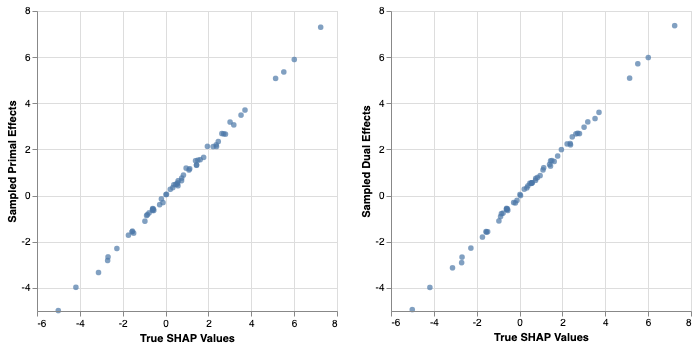

In [14]:
alt.Chart(data_df).mark_point(filled=True).encode(
    alt.X('True SHAP Values:Q'),
    alt.Y(alt.repeat("column"), type='quantitative')
).properties(width=300, height=300).repeat(column=['Sampled Primal Effects', 'Sampled Dual Effects'])

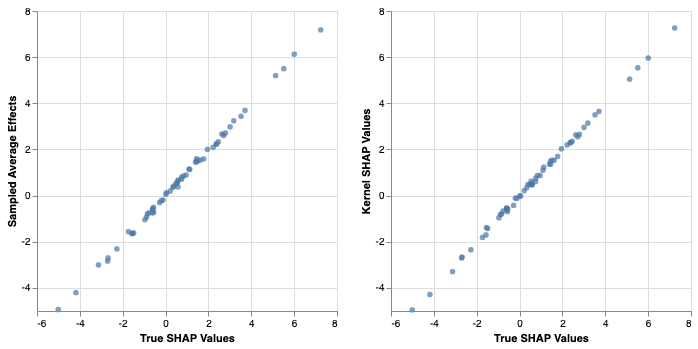

In [15]:
alt.Chart(data_df).mark_point(filled=True).encode(
    alt.X('True SHAP Values:Q'),
    alt.Y(alt.repeat("column"), type='quantitative')
).properties(width=300, height=300).repeat(column=['Sampled Average Effects', 'Kernel SHAP Values'])